In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/Deepfold2


In [3]:
import sys
sys.path.append('bin')
from genomic_data import GenomicData

In [47]:
from scipy.stats import pearsonr

In [41]:
target = GenomicData('data/icSHAPE/Spitale_2015_invitro/raw/target')
background = GenomicData('data/icSHAPE/Spitale_2015_invitro/raw/background')
target_normalized = GenomicData('data/icSHAPE/Spitale_2015_invitro/raw/target_normalized')
background_normalized = GenomicData('data/icSHAPE/Spitale_2015_invitro/raw/background_normalized')
common_names = np.intersect1d(background_normalized.names, target_normalized.names)
background_bd = {}
background_rt = {}
target_bd = {}
target_rt = {}
for name in common_names:
    background_bd[name] = background.feature('base_density', name)[1:].copy()
    background_bd[name][5:30] = 0
    background_bd[name][-30:] = 0
    background_rt[name] = background.feature('rt_stop', name)[1:].copy()
    background_rt[name][:5] = 0
    background_rt[name][-30:] = 0    
    
    target_bd[name] = target.feature('base_density', name)[1:].copy()
    target_bd[name][:5] = 0
    target_bd[name][-30:] = 0
    target_rt[name] = target.feature('rt_stop', name)[1:].copy()
    target_rt[name][:5] = 0
    target_rt[name][-30:] = 0
    
    filter_mask = (target_bd[name] >= 200) & (target_rt[name] >= 2)
    filter_mask &= (background_bd[name] >= 200) & (background_rt[name] >= 2)
    background_bd[name] = background_normalized.feature('base_density', name)[filter_mask]
    background_rt[name] = background_normalized.feature('rt_stop', name)[filter_mask]
    target_bd[name] = target_normalized.feature('base_density', name)[filter_mask]
    target_rt[name] = target_normalized.feature('rt_stop', name)[filter_mask]

In [42]:
background_bd_concat = np.concatenate([background_bd[name] for name in common_names])
background_rt_concat = np.concatenate([background_rt[name] for name in common_names])
target_bd_concat = np.concatenate([target_bd[name] for name in common_names])
target_rt_concat = np.concatenate([target_rt[name] for name in common_names])
print(background_bd_concat.shape[0], background_rt_concat.shape[0], 
      target_bd_concat.shape[0], target_rt_concat.shape[0])

(9503678, 9503678, 9503678, 9503678)


(0.52647489, 0.0)


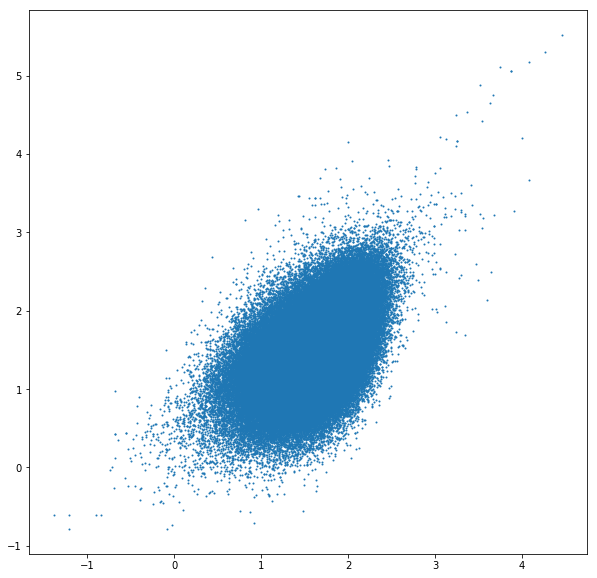

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
random_indices = np.random.choice(background_rt_concat.shape[0], size=200000)
ax.scatter(np.log10(background_rt_concat[random_indices]),
           np.log10(target_rt_concat[random_indices]), s=1)
print pearsonr(np.log10(background_rt_concat), np.log10(target_rt_concat))

In [63]:
print(target_rt_concat.mean(), background_rt_concat.mean())

(72.898109, 60.039005)


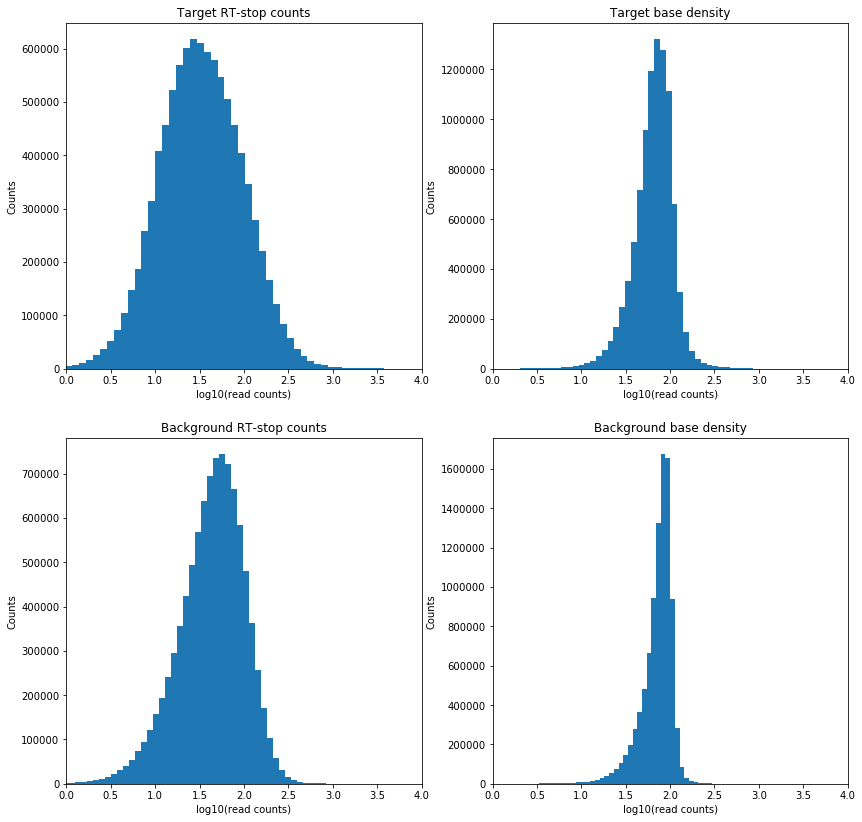

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes[0, 0].hist(np.log10(target_rt_concat), bins=100)
axes[0, 0].set_title('Target RT-stop counts')
axes[0, 1].hist(np.log10(target_bd_concat), bins=100)
axes[0, 1].set_title('Target base density')
axes[1, 0].hist(np.log10(background_rt_concat), bins=100)
axes[1, 0].set_title('Background RT-stop counts')
axes[1, 1].hist(np.log10(background_bd_concat), bins=100)
axes[1, 1].set_title('Background base density')
for i in range(2):
    for j in range(2):
        axes[i, j].set_xlabel('log10(read counts)')
        axes[i, j].set_ylabel('Counts')
        axes[i, j].set_xlim(0, 4)

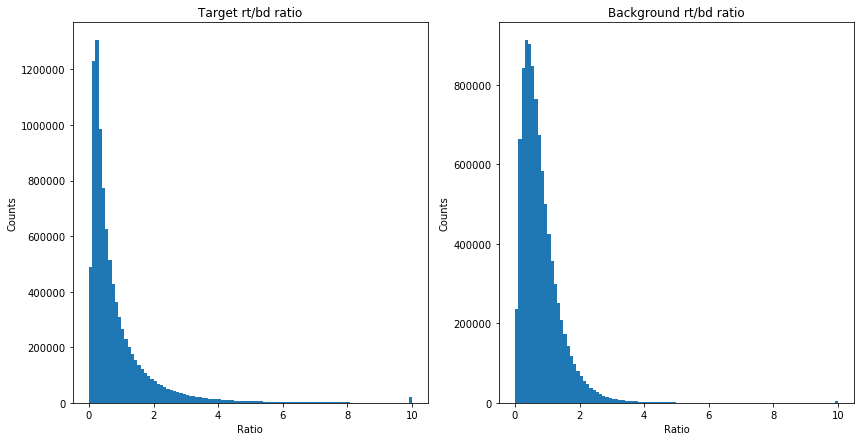

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
target_ratio = np.clip(target_rt_concat/target_bd_concat, 0, 10)
axes[0].hist(target_ratio, bins=100)
axes[0].set_xlabel('Ratio')
axes[0].set_ylabel('Counts')
axes[0].set_title('Target rt/bd ratio')

background_ratio = np.clip(background_rt_concat/background_bd_concat, 0, 10)
axes[1].hist(background_ratio, bins=100)
axes[1].set_xlabel('Ratio')
axes[1].set_ylabel('Counts')
axes[1].set_title('Background rt/bd ratio')

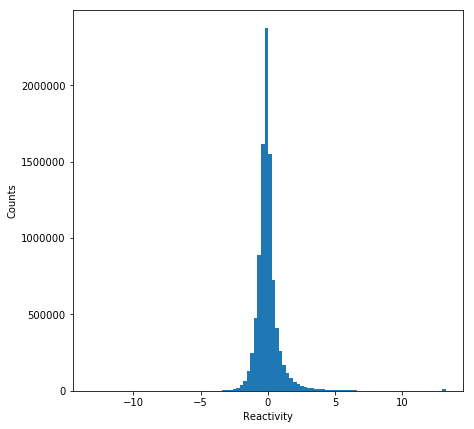

In [64]:
#bd = (target_bd_concat + background_bd_concat)*0.5
bd = background_bd_concat
r = (target_rt_concat - background_rt_concat)/bd
r_mean = r.mean()
r_std = r.std()
r = np.clip(r, r_mean - 5*r_std, r_mean + 5*r_std)
fig, ax = plt.subplots(figsize=(7, 7))
ax.hist(r, bins=100)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Counts')

In [49]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.log10(background_rt_concat).reshape((-1, 1)), np.log10(target_rt_concat))
print model.coef_, model.intercept_

[ 0.66138768] 0.438561


In [36]:
print background.feature('base_density', common_names[3])[:30]
print background_normalized.feature('base_density', common_names[3])[:30]

[    0.    99.   189.   411.   844.   915.  1306.  1480.  1528.  1578.
  1647.  1750.  2154.  2546.  2611.  2869.  2962.  3133.  3469.  3821.
  3980.  4064.  4152.  4348.  4580.  4717.  4859.  5004.  5116.  5308.]
[  0.898        1.71500003   3.72900009   7.65700006   8.30099964
  11.84799957  13.42700005  13.86200047  14.31599998  14.94200039
  15.8760004   19.54199982  23.09799957  23.68799973  26.02799988
  26.87199974  28.42300034  31.47100067  34.66500092  36.10699844
  36.86899948  37.66799927  39.44599915  41.55099869  42.79399872
  44.08200073  45.39699936  46.4129982   48.15499878  51.13100052]
